In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('../')

In [4]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [13]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json

In [14]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [15]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [70]:
num_objects = 2
noisy=False
weight_decay = 0.004
encoder_model='inceptionv3'
optimizer = 'sgd'
seed = 42

results_folder = "results/synthetic/objects={}_noisy={}_wd={}_model={}_optimizer={}_seed={}".format(
    num_objects,noisy,weight_decay,encoder_model,optimizer,seed
)

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [57]:
np.random.seed(seed)
torch.manual_seed(seed)

In [58]:
train_loader, val_loader, train_pkl, val_pkl = get_data(num_objects, noisy)
val_images, val_y, val_c = unroll_data(val_loader)

In [71]:
joint_model = get_synthetic_model(num_objects,encoder_model,noisy,weight_decay,optimizer,seed)

ConceptBottleneck/results/synthetic_2/joint_wd_0.004/joint/best_model_42.pth


## Plot the Dataset

In [11]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image.save("{}/{}.png".format(results_folder,i+1))

## Analyze Accuracy

In [72]:
train_acc, val_acc = get_accuracy(joint_model,run_joint_model,train_loader).item(), get_accuracy(joint_model,run_joint_model,val_loader).item()

In [13]:
accuracy_by_concept_train = get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True).detach().numpy()

## Analyze Concept-Task Relationships

In [14]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

## Analyze Concept-Input Relationships

### Counterfactual Images

#### Blank, Filled, and Half Images

In [40]:
no_color = torch.Tensor([0.25,0.25,0.25])
full_color = torch.Tensor([-0.25,-0.25,0.25])

In [41]:
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
full_image = full_color.clone().view(3, 1, 1).expand_as(blank_image)

half_left = no_color.view(3, 1, 1).expand_as(blank_image).clone()
half_left[:,:,:128] = full_image[:,:,:128]

half_right = no_color.clone().view(3, 1, 1).expand_as(blank_image).clone()
half_right[:,:,128:] = full_image[:,:,128:]

In [42]:
all_images = [blank_image,full_image,half_left,half_right]
all_images = torch.stack(all_images)
str_names = ["Blank","Full","Half-Left","Half-Right"]

In [43]:
y,c = run_joint_model(joint_model,all_images)
c = c.T
c = torch.nn.Sigmoid()(c).detach().numpy()
c = np.round(c,3)

### Maximal Activation

In [44]:
def numpy_to_pil(img):
    img = img.clip(0.25)
    img -= np.min(img)
    img /= (np.max(img)-np.min(img))
    im = Image.fromarray((img* 256).astype(np.uint8))

    return im

In [31]:
activation_values = []

for concept_num in range(num_objects*2):
    ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                       get_valid_image_function(concept_num,num_objects))
    activation_values.append (
        torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[concept_num][0].detach().numpy()
    )
    
    ret_image = ret_image.detach()[0].numpy().transpose((1,2,0))
    im = numpy_to_pil(ret_image) 
    im.save("{}/{}.png".format(results_folder,"adversarial_{}".format(concept_num)))


In [32]:
activation_values

[array(1., dtype=float32), array(1., dtype=float32)]

In [50]:
concept_num = 1
ret_image = get_maximal_activation(joint_model,run_joint_model,concept_num,
                                       get_valid_image_function(concept_num,num_objects))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


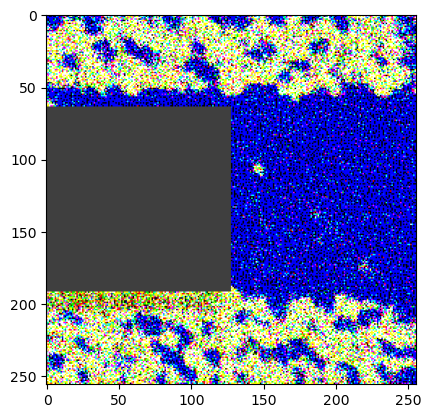

In [54]:
plt.imshow(ret_image.detach().numpy()[0].transpose(1,2,0))

In [55]:
ret_image = get_maximal_activation(joint_model,run_joint_model,1,get_valid_image_function(1,num_objects))
activation_1 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[1][0]
print(activation_1)

tensor(1., grad_fn=<SelectBackward0>)


### Patch-Based

In [54]:
grid_size = 3
concept_num = 0
grid_width = 256//grid_size
combinations = list(itertools.product([0, 1], repeat=grid_size**2))
combinations_grid = [[list(combination[i:i+grid_size]) for i in range(0, grid_size**2, grid_size)] for combination in combinations]

In [55]:
def combo_to_image(combo):
    default_image = no_color.clone().view(3, 1, 1).expand((3,256,256)).clone()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if combo[i][j] == 1:
                color_tensor = full_color.view(3, 1, 1).expand((3, grid_width, grid_width))
                default_image[:,i*grid_width:(i+1)*grid_width,j*grid_width:
                              (j+1)*grid_width] = color_tensor
                
                
    return default_image

In [56]:
def combination_to_string(combination):
    return ''.join(str(element) for row in combination for element in row)

In [57]:
all_images = torch.stack([combo_to_image(i) for i in combinations_grid])
y,c = run_joint_model(joint_model,all_images)
c = torch.nn.Sigmoid()(c)
c = c.T

In [58]:
combination_to_score = {}
for i,combination in enumerate(combinations_grid):
    condensed_string = combination_to_string(combination)
    combination_to_score[condensed_string] = c.detach().numpy()[i,concept_num]
    
largest_indices = np.argsort(c.detach().numpy()[:,0])[-25:]

In [59]:
max_dif = 0
max_ind = -1

for i in largest_indices:
    combo_original = combinations_grid[i]
    modified_combo = deepcopy(combo_original)
    for j in range(grid_size):
        modified_combo[j][-1] = 0
        
    score_original = combination_to_score[combination_to_string(combo_original)]
    score_modified = combination_to_score[combination_to_string(modified_combo)]

    if score_original-score_modified > max_dif:
        max_dif = score_original-score_modified
        max_ind = i

In [60]:
combo_original = combinations_grid[max_ind]
modified_combo = deepcopy(combo_original)
for j in range(grid_size):
    modified_combo[j][-1] = 0

In [63]:
im_original = numpy_to_pil(combo_to_image(combo_original).detach().numpy().transpose((1,2,0)))
im_final = numpy_to_pil(combo_to_image(modified_combo).detach().numpy().transpose((1,2,0)))

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [64]:
im_original.save("{}/{}.png".format(results_folder,'original_combo'))
im_final.save("{}/{}.png".format(results_folder,'modified_combo'))

In [65]:
max_dif

0

### Saliency Maps

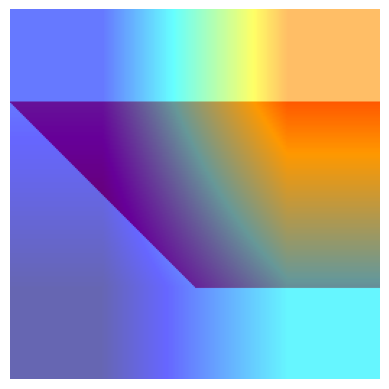

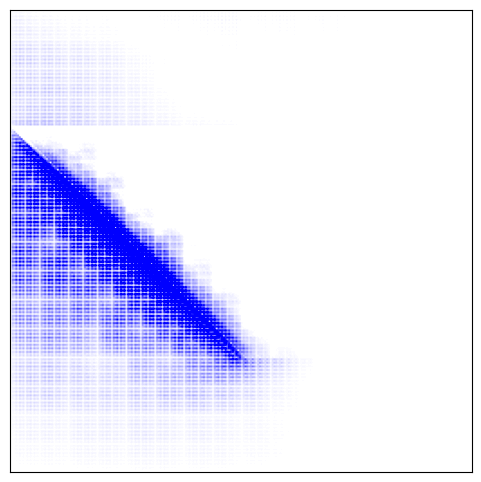

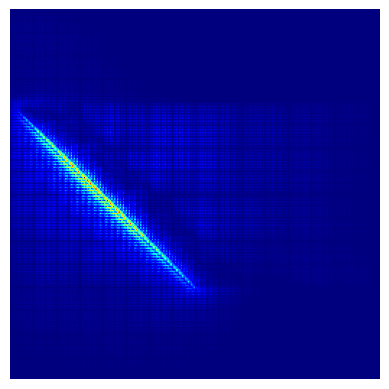

<Figure size 640x480 with 0 Axes>

In [72]:
for method, method_name in zip(
    [plot_gradcam,plot_integrated_gradients,plot_saliency],
    ['gradcam','integrated_gradients','saliency']
):
    plt.axis('off')
    method(joint_model,run_joint_model,0,val_images,0,val_pkl)
    plt.savefig('{}/{}.png'.format(results_folder,method_name),bbox_inches='tight')

In [97]:
final_data = {
    'train_accuracy': train_acc, 
    'val_accuracy': val_acc, 
    'concept_accuracy': accuracy_by_concept_train.tolist(), 
    'adversarial_activations': np.array(activation_values).tolist(),  
    'grid_dif': max_dif, 
}

In [98]:
json.dump(final_data,open("{}/results.json".format(results_folder),"w"))